# OrgaTuring: AI Deciphers Organoids towards Futurizing Healthcare 

- CNN with Interpretability Pipeline to localize, quantize, and classify Organoid Inflamed and Non-Inflamed images

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:XLA_CPU:0 || Unnamed device || XLA_CPU || 16.0 GiB
 /device:XLA_GPU:0 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:1 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:2 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:3 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:GPU:0 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:1 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:2 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:3 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB


2022-09-29 13:47:01.509186: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-09-29 13:47:01.553236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3499710000 Hz
2022-09-29 13:47:01.554183: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55709f0bd6e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-29 13:47:01.554221: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-29 13:47:01.559114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-29 13:47:03.706889: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55709f1513d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-09-29 13:47:03.706948: I tensor

In [3]:
#import packages
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
import splitfolders
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
import sklearn

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from tensorflow.keras.layers import Input, Flatten, SeparableConv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import glob
import cv2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from skimage.io import imread
from tensorflow.keras.applications import vgg16

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="png"


In [3]:
tf.config.experimental.list_physical_devices()

2022-09-29 13:47:32.946195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-29 13:47:32.947607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-29 13:47:32.948802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-29 13:47:32.950107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 3 with properties: 
pciBusID: 0000:82:00.0 n

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
IMG_SIZE = 224
# BATCH = 32
BATCH = 32
SEED = 42
GPUS = ["GPU:0", "GPU:1", "GPU:2","GPU:3"]

In [5]:
# # strategy = tf.distribute.MirroredStrategy(GPUS)
# print('Number of devices: %d' % strategy.num_replicas_in_sync) 

In [6]:
# batch_size = BATCH * strategy.num_replicas_in_sync

In [7]:
# batch_size

- Splitting the Dataset into train, test, and valid

In [8]:
# # Creating Train, Test, and Valid Dataset
# input_folder = "../../../aman/Updated_Dataset_2D/Sorted/"


In [9]:
# # Split with a ratio.

# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# # Train, val, test
# splitfolders.ratio(input_folder, output="./dataset/raw_dataset_update/", 
#                    seed=42, ratio=(.7, .15, .15), 
#                    group_prefix=None) # default values

In [10]:
train_dir = os.path.join("./dataset/aug_dataset_update/train/")
valid_dir = os.path.join('./dataset/aug_dataset_update/val/')
test_dir = os.path.join('./dataset/aug_dataset_update/test/')

train_i_dir = os.path.join('./dataset/aug_dataset_update/train/Inflamed/')
train_ni_dir = os.path.join('./dataset/aug_dataset_update/train/NonInflamed/')

valid_i_dir = os.path.join('./dataset/aug_dataset_update/val/Inflamed/')
valid_ni_dir = os.path.join('./dataset/aug_dataset_update/val/NonInflamed')

test_i_dir = os.path.join('./dataset/aug_dataset_update/test/Inflamed/')
test_ni_dir = os.path.join('./dataset/aug_dataset_update/test/NonInflamed')
# train_dir = os.path.join("./dataset/raw_dataset/train/")
# valid_dir = os.path.join('./dataset/raw_dataset/val/')
# test_dir = os.path.join('./dataset/raw_dataset/test/')

# train_i_dir = os.path.join('./dataset/raw_dataset/train/Inflamed/')
# train_ni_dir = os.path.join('./dataset/raw_dataset/train/NonInflamed/')

# valid_i_dir = os.path.join('./dataset/raw_dataset/val/Inflamed/')
# valid_ni_dir = os.path.join('./dataset/raw_dataset/val/NonInflamed')

# test_i_dir = os.path.join('./dataset/raw_dataset/test/Inflamed/')
# test_ni_dir = os.path.join('./dataset/raw_dataset/test/NonInflamed')

In [11]:
train_i_names = os.listdir(train_i_dir)
print(train_i_names [:10])

train_ni_names  = os.listdir(train_ni_dir)
print(train_ni_names [:10])

valid_i_names = os.listdir(valid_i_dir)
print(valid_i_names[:10])

valid_ni_names = os.listdir(valid_ni_dir)
print(valid_ni_names[:10])

test_i_names = os.listdir(test_i_dir)
print(test_i_names[:10])

test_ni_names = os.listdir(test_ni_dir)
print(test_ni_names[:10])

['CD41-I-I p3 10x 9-19-19_0_250.tif', 'CD63-I-I P2 200313 4X_0_9212.tif', 'CD41-I-I p3 4x 9-19-19_0_5314.tif', 'CD62-I-I P3 200311 4X_0_8034.tif', 'CD11 IL-I-QS_2501 40x 190603_0_1363.tif', 'CD11 IL-I-QS_2504 40x 190603_0_4388.tif', 'CD11 ILEUM I _0_4379.tif', 'CD11 IL-I-QS_2503 40x 190603_0_2238.tif', 'CD42-I-I P2 190920 10X_0_4000.tif', 'CD13-Il-I_QS_2479_0_5773.tif']
['CD19-LC-NI P6 191002 10X 1_0_6641.tif', 'CD10-R-NI_QS_2465_0_8809.tif', 'CD47-I-NI P3 191029 4X_0_6024.tif', 'CD11-LC-NI P12 190905 4x.tif', 'CD22-LC-NI P2 190708 10x _0_849.tif', 'CD23-LC-NI P1 190701 10x_0_4390.tif', 'CD27-I-NI P0 190625 4X_0_884.tif', 'CD50-I-NI P3 191212 10X_0_7715.tif', 'CD24-I-NI P1 190620 4X.tif', 'CD48-RC P5 5x 03.05.20_0_1163.tif']
['CD62-I-I P1 202026 10X.JPG', 'CD41-I-I P2 190909 10x .tif', 'CD63-I-I P3 200318 4X.JPG', 'CD11 IL-I-QS_2497 20x 190603.tif', 'CD42-I-I P2 190920 4X.tif', 'CD62-I-I P2 200304 10X.JPG', 'CD11 IL-I-QS_2494 10x 190603.tif']
['CD62-R-NI P1 10x 02.23.20.JPG', 'CD47-I-N

In [12]:
print('total training i images:', len(os.listdir(train_i_dir)))
print('total training ni images:', len(os.listdir(train_ni_dir)))
print('total validation i images:', len(os.listdir(valid_i_dir)))
print('total validation ni images:', len(os.listdir(valid_ni_dir)))
print('total testing i images:', len(os.listdir(test_i_dir)))
print('total testing ni images:', len(os.listdir(test_ni_dir)))

num_train_i =  len(os.listdir(train_i_dir))
num_train_ni =  len(os.listdir(train_ni_dir))
num_val_i =  len(os.listdir(valid_i_dir))
num_val_ni =  len(os.listdir(valid_ni_dir))
num_test_i =  len(os.listdir(test_i_dir))
num_test_ni =  len(os.listdir(test_ni_dir))

total_train =num_train_i  + num_train_ni
total_val = num_val_i  + num_val_ni
total_test = num_test_i   + num_test_ni 

print("-----------------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total testing images:", total_test)

total training i images: 680
total training ni images: 5018
total validation i images: 7
total validation ni images: 53
total testing i images: 8
total testing ni images: 55
-----------------------------------------------------
Total training images: 5698
Total validation images: 60
Total testing images: 63


In [13]:
train_i = glob.glob(train_i_dir+"/*.*")
train_ni = glob.glob(train_ni_dir+"/*.*")
# train_i_names

In [14]:
valid_i = glob.glob(valid_i_dir+"/*.*")
valid_ni = glob.glob(valid_ni_dir+"/*.*")
# train_i_names

In [15]:
test_i = glob.glob(test_i_dir+"/*.*")
test_ni = glob.glob(test_ni_dir+"/*.*")
# train_i_names

In [16]:
train_list = [x for x in train_i]
train_list.extend([x for x in train_ni])

df_train = pd.DataFrame(np.concatenate([['Inflamed']*len(train_i) , ['NonInflamed']*len(train_ni)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

In [17]:
valid_list = [x for x in valid_i]
valid_list.extend([x for x in valid_ni])

df_valid = pd.DataFrame(np.concatenate([['Inflamed']*len(valid_i) , ['NonInflamed']*len(valid_ni)]), columns = ['class'])
df_valid['image'] = [x for x in valid_list]

In [18]:
test_list = [x for x in test_i]
test_list.extend([x for x in test_ni])

df_test = pd.DataFrame(np.concatenate([['Inflamed']*len(test_i) , ['NonInflamed']*len(test_ni)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [19]:
df_train

,class,image
0,Inflamed,./dataset/aug_dataset_update/train/Inflamed/CD41-I-I p3 10x 9-19-19_0_250.tif
1,Inflamed,./dataset/aug_dataset_update/train/Inflamed/CD63-I-I P2 200313 4X_0_9212.tif
2,Inflamed,./dataset/aug_dataset_update/train/Inflamed/CD41-I-I p3 4x 9-19-19_0_5314.tif
3,Inflamed,./dataset/aug_dataset_update/train/Inflamed/CD62-I-I P3 200311 4X_0_8034.tif
4,Inflamed,./dataset/aug_dataset_update/train/Inflamed/CD11 IL-I-QS_2501 40x 190603_0_1363.tif
...,...,...
5693,NonInflamed,./dataset/aug_dataset_update/train/NonInflamed/CD28-R-NI P2 190707 4X.tif
5694,NonInflamed,./dataset/aug_dataset_update/train/NonInflamed/CD51-R-NI P7 200116 4X_0_8109.tif
5695,NonInflamed,./dataset/aug_dataset_update/train/NonInflamed/CD30-I-NI P4 190814 4X_0_5457.tif
5696,NonInflamed,./dataset/aug_dataset_update/train/NonInflamed/CD42-R-NI P6 191009 4X_0_2824.tif


In [20]:
class_i = df_train[df_train['class'] == 'Inflamed']
class_ni = df_train[df_train['class'] == 'NonInflamed']


In [21]:
# class_i

In [22]:
# class_ni

In [23]:
# Convert parts into NumPy arrays for weight computation
i_numpy = class_i['class'].to_numpy()
ni_numpy = class_ni['class'].to_numpy()


In [24]:
all_together = np.concatenate((i_numpy, ni_numpy))
unique_classes = np.unique(all_together)

In [25]:
# weights = class_weight.compute_class_weight('balanced', unique_classes, all_together)
# print(weights)

In [26]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(all_together), y = all_together )

In [27]:
class_weights = dict(enumerate(class_weights))

In [28]:
class_weights

{0: 4.189705882352941, 1: 0.5677560781187724}

In [29]:
# df_valid.head(20)

In [30]:
# df_test.head(20)

In [31]:
# plt.figure(figsize=(6,4))

# ax = sns.countplot(x='class', data=df_train, palette="mako")

# plt.xlabel("Class", fontsize= 12)
# plt.ylabel("No of Samples", fontsize= 12)
# plt.ylim(0,800)
# plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

# for p in ax.patches:
#     ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
# plt.show()

In [32]:
# plt.figure(figsize=(7,5))

# df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

# plt.legend(labels=['Inflamed', 'NonInflamed'])
# plt.show()

In [33]:
# plt.figure(figsize=(6,4))

# ax = sns.countplot(x='class', data=df_test, palette="mako")

# plt.xlabel("Class", fontsize= 12)
# plt.ylabel("No of Samples", fontsize= 12)
# plt.ylim(0,200)
# plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

# for p in ax.patches:
#     ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
# plt.show()

In [34]:
# plt.figure(figsize=(7,5))

# df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

# plt.legend(labels=['Inflamed', 'NonInflamed'])
# plt.show()

In [35]:
# print('Train Set - Inflamed')

# plt.figure(figsize=(12,12))

# for i in range(0, 12):
#     plt.subplot(3,4,i + 1)
#     img = cv2.imread(train_i[i])
#     img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
#     plt.imshow(img)
#     plt.axis("off")

# plt.tight_layout()

# plt.show()

In [36]:
# print('Train Set - NonInflamed')

# plt.figure(figsize=(12,12))

# for i in range(0, 12):
#     plt.subplot(3,4,i + 1)
#     img = cv2.imread(train_ni[i])
#     img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
#     plt.imshow(img)
#     plt.axis("off")

# plt.tight_layout()

# plt.show()

In [37]:
train_datagen = ImageDataGenerator(rescale=1/255.)
# train_datagen = ImageDataGenerator(
#         rescale=1/255.,
#         rotation_range=10, # rotation
#         width_shift_range=0.2, # horizontal shift
#         height_shift_range=0.2, # vertical shift
#         zoom_range=0.2, # zoom
#         horizontal_flip=True, # horizontal flip
#         vertical_flip= True,
#         fill_mode = 'reflect',
#         brightness_range=[0.2,1.2])

valid_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale = 1/255.)                                

In [38]:
ds_train = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = BATCH,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'Inflamed': 0., 'NonInflamed': 1.}
                                                 )

Found 5698 images belonging to 2 classes.


In [39]:
ds_valid = valid_datagen.flow_from_directory(valid_dir,
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = BATCH,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'Inflamed': 0., 'NonInflamed': 1.}
                                                 )

Found 60 images belonging to 2 classes.


In [40]:
ds_test = test_datagen.flow_from_directory(test_dir ,
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            shuffle=False,
                                            classes={'Inflamed': 0., 'NonInflamed': 1.}
                                            )

Found 63 images belonging to 2 classes.


In [41]:
# # Get few samples for both the classes
# inflamed_samples = (df_train[df_train['class']=='Inflamed']['image'].iloc[:5]).tolist()
# noninflamed_samples = (df_train[df_train['class']=='NonInflamed']['image'].iloc[:5]).tolist()

# # Concat the data in a single list and del the above two list
# samples = inflamed_samples + noninflamed_samples
# del inflamed_samples, noninflamed_samples

# # Plot the data 
# f, ax = plt.subplots(2,5, figsize=(20,6))
# for i in range(10):
#     img = imread(samples[i])
#     ax[i//5, i%5].imshow(img)
#     if i<5:
#         ax[i//5, i%5].set_title("Inflamed")
#     else:
#         ax[i//5, i%5].set_title("NonInflamed")
#     ax[i//5, i%5].axis('off')
#     ax[i//5, i%5].set_aspect('auto')
# plt.show()

In [42]:
checkpoint_path = "./checkpoint_path/final_cnn_transfer/training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [43]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [44]:
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint_path/final_cnn_transfer/training_4/model{epoch:08d}.h5',save_freq='epoch', period=10) 

In [48]:
#Setting callbakcs

# early_stopping = callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     min_delta=1e-7,
#     restore_best_weights=True,
# )

# plateau = callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor = 0.2,                                     
#     patience = 2,                                   
#     min_delt = 1e-7,                                
#     cooldown = 0,                               
#     verbose = 1
# )

In [49]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [50]:
# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [51]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
optimizer = RMSprop(0.0001)
model_pretrained.compile(loss=focal_loss()
              , optimizer = optimizer, metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [52]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_valid,
        #   callbacks=[early_stopping, plateau, cp_callback, checkpoint],
          callbacks=[cp_callback, checkpoint],
          class_weight = class_weights,
          steps_per_epoch=(len(df_train)/BATCH),
          validation_steps=(len(df_valid)/BATCH));

Epoch 1/50


2022-09-28 22:46:24.718936: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-28 22:46:26.997475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


5/4 [=================================] - ETA: -1s - loss: 0.1526 - binary_accuracy: 0.5439
Epoch 00001: saving model to ./checkpoint_path/final_cnn_transfer/training_4/cp.ckpt
5/4 [=================================] - 21s 4s/step - loss: 0.1526 - binary_accuracy: 0.5439 - val_loss: 0.0872 - val_binary_accuracy: 0.3500
Epoch 2/50
5/4 [=================================] - ETA: -1s - loss: 0.0885 - binary_accuracy: 0.3298
Epoch 00002: saving model to ./checkpoint_path/final_cnn_transfer/training_4/cp.ckpt
5/4 [=================================] - 18s 4s/step - loss: 0.0885 - binary_accuracy: 0.3298 - val_loss: 0.0976 - val_binary_accuracy: 0.1875
Epoch 3/50
5/4 [=================================] - ETA: -1s - loss: 0.0751 - binary_accuracy: 0.3193
Epoch 00003: saving model to ./checkpoint_path/final_cnn_transfer/training_4/cp.ckpt
5/4 [=================================] - 18s 4s/step - loss: 0.0751 - binary_accuracy: 0.3193 - val_loss: 0.0800 - val_binary_accuracy: 0.2875
Epoch 4/50
5/4 

KeyboardInterrupt: 

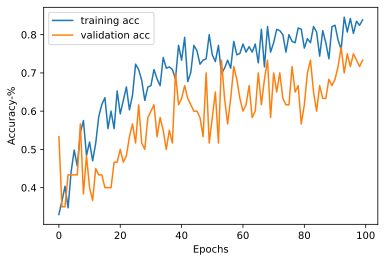

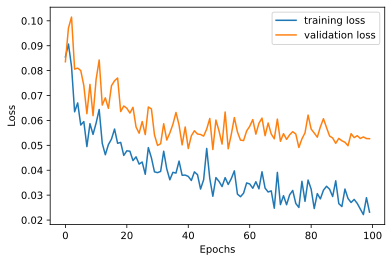

In [85]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plot_learning_curve(history)

In [86]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03468078374862671
Test accuracy: 0.8730158805847168


In [87]:
num_label = {'Inflamed': 0, 'NonInflamed' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [88]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [89]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.873015873015873


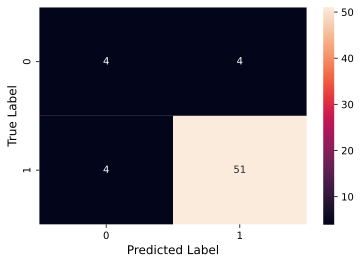

In [90]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [91]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.93      0.93      0.93        55

    accuracy                           0.87        63
   macro avg       0.71      0.71      0.71        63
weighted avg       0.87      0.87      0.87        63



ROC_AUC:  0.8613636363636363


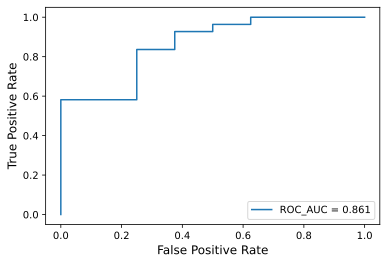

In [92]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

# Training 2

In [51]:
tf.keras.backend.clear_session()

In [52]:

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

  

In [53]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
            , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [54]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 100,
          validation_data=ds_valid,
          callbacks=[cp_callback, checkpoint],
          class_weight = class_weights,
          steps_per_epoch=(len(df_train)/BATCH),
          validation_steps=(len(df_valid)/BATCH));

Epoch 1/100
5/4 [=================================] - ETA: -1s - loss: 0.7261 - binary_accuracy: 0.7088
Epoch 00001: saving model to ./checkpoint_path/final_cnn_transfer/training_2/cp.ckpt
5/4 [=================================] - 18s 4s/step - loss: 0.7261 - binary_accuracy: 0.7088 - val_loss: 0.6405 - val_binary_accuracy: 0.6500
Epoch 2/100
5/4 [=================================] - ETA: -1s - loss: 0.7066 - binary_accuracy: 0.6386
Epoch 00002: saving model to ./checkpoint_path/final_cnn_transfer/training_2/cp.ckpt
5/4 [=================================] - 19s 4s/step - loss: 0.7066 - binary_accuracy: 0.6386 - val_loss: 0.6595 - val_binary_accuracy: 0.5667
Epoch 3/100
5/4 [=================================] - ETA: -1s - loss: 0.6960 - binary_accuracy: 0.6456
Epoch 00003: saving model to ./checkpoint_path/final_cnn_transfer/training_2/cp.ckpt
5/4 [=================================] - 20s 4s/step - loss: 0.6960 - binary_accuracy: 0.6456 - val_loss: 0.6608 - val_binary_accuracy: 0.6167
E

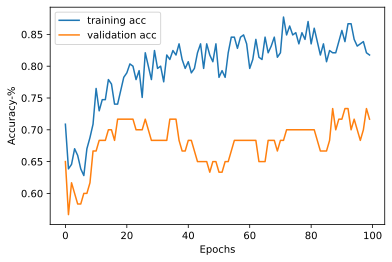

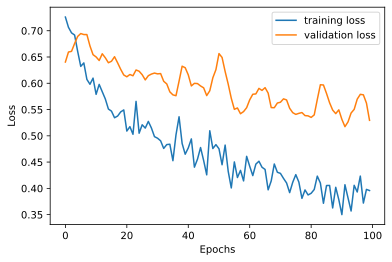

In [56]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plot_learning_curve(history)

In [46]:
output = load_model('./checkpoint_path/final_cnn_transfer/training_2/model00000099.h5')

In [47]:
output.compile(loss='binary_crossentropy'
            , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

output.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [48]:
score = output.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2022-09-28 10:08:54.538248: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-28 10:08:54.708695: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


Test loss: 0.3878220319747925
Test accuracy: 0.8730158805847168


In [49]:
num_label = {'Inflamed': 0, 'NonInflamed' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [50]:
ds_test.reset()
predictions = output.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [51]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.873015873015873


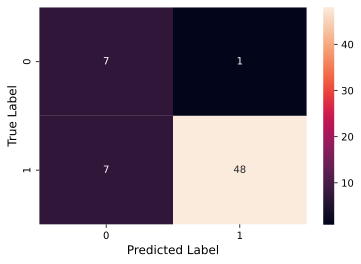

In [52]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [53]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.50      0.88      0.64         8
           1       0.98      0.87      0.92        55

    accuracy                           0.87        63
   macro avg       0.74      0.87      0.78        63
weighted avg       0.92      0.87      0.89        63



ROC_AUC:  0.8681818181818182


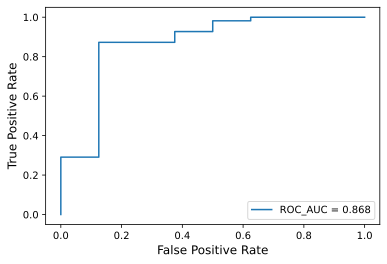

In [54]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [55]:
#Identify all images classified as parasitized
inflamed_image_idx = np.where(pred_labels == 0)[0]

In [60]:
num_label = {'Inflamed': 0, 'NonInflamed' : 1}
X_test = df_test['image']

In [62]:
predicted_as_para=[]
for i in inflamed_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)  

In [63]:
predicted_as_para = np.array(predicted_as_para)   

# Training_3

In [47]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [48]:
# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [49]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
optimizer = RMSprop(0.0001)
model_pretrained.compile(loss=focal_loss()
              , optimizer = optimizer, metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [50]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 10,
          validation_data=ds_valid,
        #   callbacks=[early_stopping, plateau, cp_callback, checkpoint],
          callbacks=[cp_callback, checkpoint],
          class_weight = class_weights,
          steps_per_epoch=(len(df_train)/BATCH),
          validation_steps=(len(df_valid)/BATCH));

Epoch 1/10


2022-09-28 11:03:34.665161: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-28 11:03:35.487869: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


179/178 [==============================] - ETA: -1s - loss: 0.1126 - binary_accuracy: 0.4839
Epoch 00001: saving model to ./checkpoint_path/final_cnn_transfer/training_3/cp.ckpt
179/178 [==============================] - 390s 2s/step - loss: 0.1126 - binary_accuracy: 0.4839 - val_loss: 0.0660 - val_binary_accuracy: 0.4667
Epoch 2/10
179/178 [==============================] - ETA: -1s - loss: 0.0572 - binary_accuracy: 0.6372
Epoch 00002: saving model to ./checkpoint_path/final_cnn_transfer/training_3/cp.ckpt
179/178 [==============================] - 359s 2s/step - loss: 0.0572 - binary_accuracy: 0.6372 - val_loss: 0.0527 - val_binary_accuracy: 0.6833
Epoch 3/10
179/178 [==============================] - ETA: -1s - loss: 0.0455 - binary_accuracy: 0.7143
Epoch 00003: saving model to ./checkpoint_path/final_cnn_transfer/training_3/cp.ckpt
179/178 [==============================] - 334s 2s/step - loss: 0.0455 - binary_accuracy: 0.7143 - val_loss: 0.0517 - val_binary_accuracy: 0.7000
Epoch 

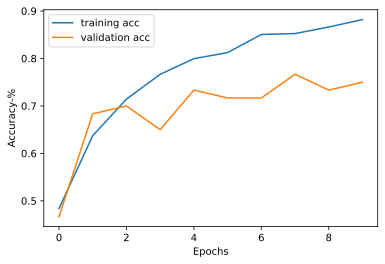

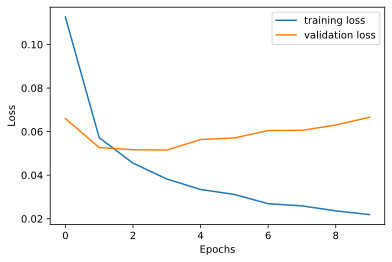

In [51]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plot_learning_curve(history)

In [52]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04600038379430771
Test accuracy: 0.8730158805847168


In [53]:
num_label = {'Inflamed': 0, 'NonInflamed' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [54]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [55]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.873015873015873


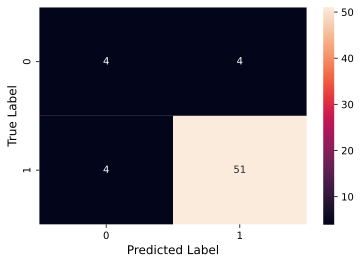

In [56]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [57]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.93      0.93      0.93        55

    accuracy                           0.87        63
   macro avg       0.71      0.71      0.71        63
weighted avg       0.87      0.87      0.87        63



ROC_AUC:  0.7613636363636364


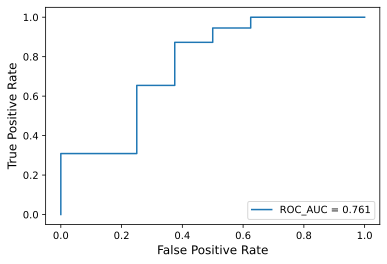

In [58]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [59]:
output_1 = load_model('./checkpoint_path/training_2/model00000200.h5')

In [60]:
output_1.compile(loss='binary_crossentropy'
            , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

output_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [107]:
score = output_1.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25276386737823486
Test accuracy: 0.930232584476471


In [108]:
num_label = {'Inflamed': 0, 'NonInflamed' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [110]:
ds_test.reset()
predictions = output_1.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [111]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9302325581395349


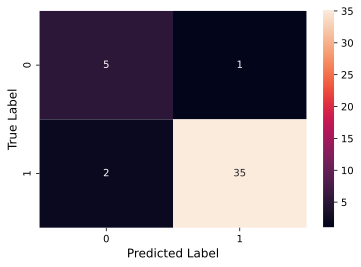

In [112]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [113]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.97      0.95      0.96        37

    accuracy                           0.93        43
   macro avg       0.84      0.89      0.86        43
weighted avg       0.94      0.93      0.93        43



ROC_AUC:  0.891891891891892


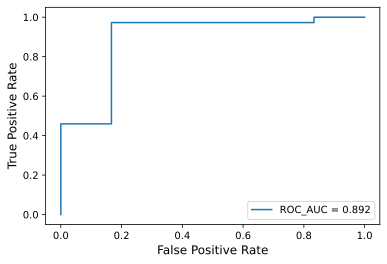

In [114]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

# Training 4

In [51]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

2022-09-28 23:20:57.865541: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-28 23:20:59.266077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-28 23:20:59.266814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-28 23:20:59.267529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2

In [52]:
# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [53]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
optimizer = RMSprop(0.0001)
model_pretrained.compile(loss=focal_loss()
              , optimizer = optimizer, metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 58,594,178
Trainable params: 4,731,266
Non-trainable params: 53,862,912
_________________________________________

In [54]:
history_new = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 100,
          validation_data=ds_valid,
          callbacks=[cp_callback, checkpoint],
          class_weight = class_weights,
          steps_per_epoch=(len(df_train)/BATCH),
          validation_steps=(len(df_valid)/BATCH));

Epoch 1/100


2022-09-28 23:22:00.463264: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-28 23:22:03.747299: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


90/89 [==============================] - ETA: -4s - loss: 0.1050 - binary_accuracy: 0.5000
Epoch 00001: saving model to ./checkpoint_path/final_cnn_transfer/training_4/cp.ckpt
90/89 [==============================] - 395s 4s/step - loss: 0.1050 - binary_accuracy: 0.5000 - val_loss: 0.0569 - val_binary_accuracy: 0.5000
Epoch 2/100
90/89 [==============================] - ETA: -4s - loss: 0.0871 - binary_accuracy: 0.5000
Epoch 00002: saving model to ./checkpoint_path/final_cnn_transfer/training_4/cp.ckpt
90/89 [==============================] - 386s 4s/step - loss: 0.0871 - binary_accuracy: 0.5000 - val_loss: 0.0539 - val_binary_accuracy: 0.5000
Epoch 3/100
90/89 [==============================] - ETA: -3s - loss: 0.0867 - binary_accuracy: 0.5000
Epoch 00003: saving model to ./checkpoint_path/final_cnn_transfer/training_4/cp.ckpt
90/89 [==============================] - 359s 4s/step - loss: 0.0867 - binary_accuracy: 0.5000 - val_loss: 0.0534 - val_binary_accuracy: 0.5000
Epoch 4/100
52/8

KeyboardInterrupt: 

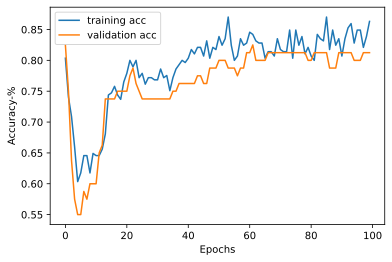

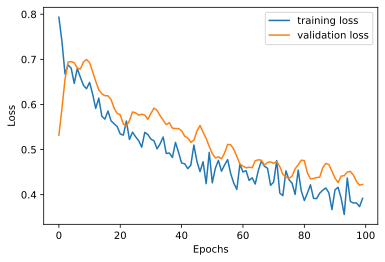

In [52]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plot_learning_curve(history)

In [53]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.43268918991088867
Test accuracy: 0.8139534592628479


In [54]:
num_label = {'Inflamed': 0, 'NonInflamed' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [55]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [56]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.813953488372093


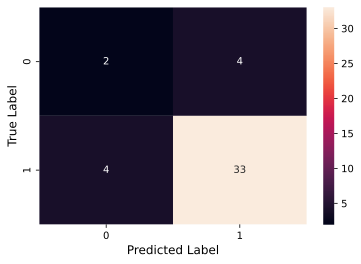

In [57]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [58]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.89      0.89      0.89        37

    accuracy                           0.81        43
   macro avg       0.61      0.61      0.61        43
weighted avg       0.81      0.81      0.81        43



ROC_AUC:  0.7747747747747747


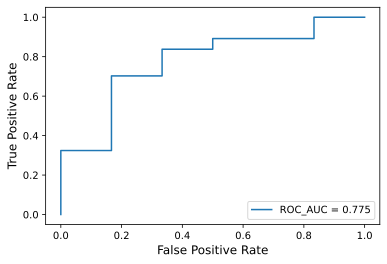

In [59]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()